<a href="https://colab.research.google.com/github/MarkoBrie/Image-Classification-with-CNN-and-data-augmentation/blob/main/1_EDA_Texte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name='0'></a>
# 0 Sommaire

- [ Sommaire](#0)
- [ 1 - Configurer le noyau et les dépendances nécessaires](#1)
- [ 2 - Préparation du jeu de donnée](#2)
  - [ 2.0 - Charger le jeu de donnée CSV avec catégorie](#2.0)
  - [ 2.1 - Charger les images](#2.1)

<a name='1'></a>
# 1 - Configurer le noyau et les dépendances nécessaires

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

import nltk
from nltk.stem.snowball import FrenchStemmer
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS

# Import des librairies
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


<a name='2'></a>
# 2 Préparation du jeu de donnée

In [ ]:
# Specify the path to your CSV file
file_path = './Flipkart/flipkart_com-ecommerce_sample_1050.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
#print(df.head())

## Category Split

In [ ]:
df.product_category_tree[0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [ ]:
def cat_seperator_fct(sentence):
    sentence_clean = sentence.replace('["','')
    first_cat = sentence_clean.split(" >> ")[0]
    return first_cat

df['product_category_tree_1'] = df['product_category_tree'].apply(cat_seperator_fct)
df['product_category_tree_1']

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: product_category_tree_1, Length: 1050, dtype: object

In [ ]:
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,product_category_tree_1
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care


In [ ]:
df.to_csv("./Flipkart/flipkart_com-ecommerce_sample_1050_with_CAT.csv", index=False)

In [ ]:
l_cat = list(set(df['product_category_tree_1']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df.iloc[i]['product_category_tree_1'])) for i in range(len(df))]
print(len(y_cat_num))

catégories :  ['Home Decor & Festive Needs', 'Baby Care', 'Kitchen & Dining', 'Computers', 'Home Furnishing', 'Beauty and Personal Care', 'Watches']
1050


In [ ]:
df.description

0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel (...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, Length: 1050, dtype: object

In [ ]:
df['_prodName_Description'] = df['product_name']+df['description']
df.shape

In [ ]:
#df

In [ ]:
#nltk.download()
#pip install nltk

## Stop words

In [ ]:
def stop_words_fct(df) :
    # Premièrement, on récupère la fréquence totale de chaque mot
    freq_totale = nltk.Counter()

    tokenizer = nltk.RegexpTokenizer(r'\w+')
    stats, freq = dict(), dict()
    corpus = defaultdict(list)

    # iterate through the DataFrame
    for index, row in df.iterrows():
        corpus[row['uniq_id']] += tokenizer.tokenize(row['description'].lower())

    for k, v in corpus.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}

    for k, v in corpus.items():
        #print('k ', k, ' v ', v)
        freq_totale += freq[k]

    # Deuxièmement on décide manière un peu arbitraire du nombre de mots les plus fréquents à supprimer.
    # On pourrait afficher un graphe d'évolution du nombre de mots pour se rendre compte et
    # avoir une meilleure heuristique.
    most_freq, frequency = zip(*freq_totale.most_common(38))

    # On créé notre set de stopwords final qui cumule ainsi les 38 mots les plus fréquents
    # du corpus ainsi que l'ensemble de stopwords par défaut présent dans la librairie NLTK
    sw = set()
    sw.update(tuple(nltk.corpus.stopwords.words('english')))
    sw.update(most_freq)

    print('number of stop words : ', len(sw))
    return sw

sw = stop_words_fct(df)



number of stop words :  199


## Stemmer

In [ ]:
from collections import defaultdict
stats, freq = dict(), dict()
corpus = defaultdict(list)
tokenizer = nltk.RegexpTokenizer(r'\w+')
# iterate through the DataFrame
for index, row in df.iterrows():
    corpus[row['uniq_id']] += tokenizer.tokenize(row['description'].lower())
    #print(f"ID: {row['uniq_id']}, Value: {tokenizer.tokenize(row['description'].lower())}")

for k, v in corpus.items():
    #print("k ", k , "  v ", v)
    #print('freq = ', nltk.FreqDist(v))
    freq[k] = fq = nltk.FreqDist(v)
    stats[k] = {'total': len(v), 'unique': len(fq.keys())}

df_stats = pd.DataFrame.from_dict(stats, orient='index')
df_stats.shape

<Axes: title={'center': 'Produits par nombre de mots dans description'}>

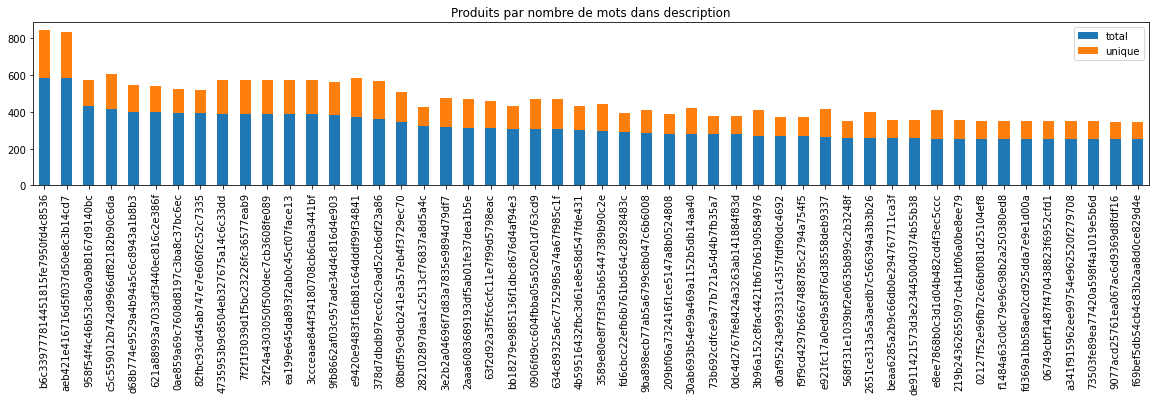

In [ ]:
# Affichage des fréquences
df_stats = df_stats.sort_values(by=['total'], ascending=False)
df_stats[:50].plot.bar( title='Produits par nombre de mots dans description',
                   figsize=(20,3),
                    #color=['blue', 'orange'],
                  stacked=True)


In [ ]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('.', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :

    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]

    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

def stemmer_fct(list_words) :

    stem_w = [stemmer.stem(w) for w in list_words if not w in list(sw)]

    return stem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization and stemmer
def transform_bow_lem_stem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    stem_w = stemmer_fct(lem_w)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

df['sentence_bow'] = df['description'].apply(lambda x : transform_bow_fct(x))
df['sentence_bow_lem'] = df['description'].apply(lambda x : transform_bow_lem_fct(x)) # Word2Vec
df['sentence_bow_lem_stem'] = df['description'].apply(lambda x : transform_bow_lem_stem_fct(x))
df['sentence_dl'] = df['description'].apply(lambda x : transform_dl_fct(x)) # BERT, USE

df['sentence_bow_lem_stem'] = df['description'].apply(transform_bow_lem_stem_fct)
df.shape

(1050, 21)

In [ ]:
df['description'][0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [ ]:
df['sentence_bow_lem_stem'][0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 height pack price 899 this curtain enhances look interior this curtain made 100 high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving this curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal design the surreal attention sure steal heart these contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight specification elegance polyester multicolor abstract eyelet door curtain 213 height pack general brand elegance designed for door type eyelet model name abstract polyester door curtain set model duster25 color multicolor di

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


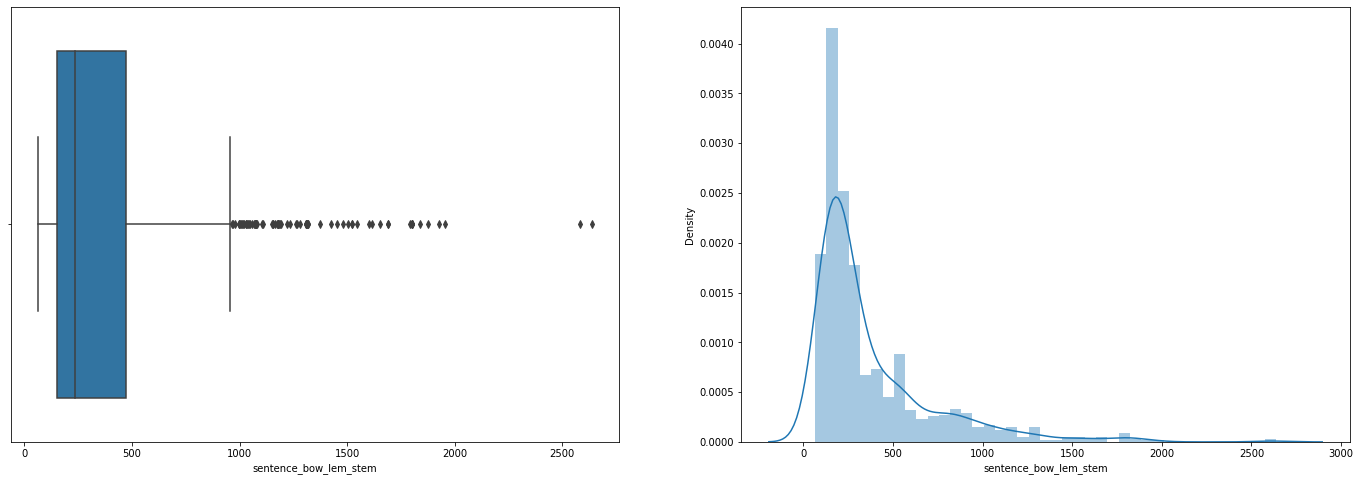

In [ ]:
tmp = df['sentence_bow_lem_stem'].str.len()
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24,8))
sns.boxplot(tmp, ax=axes[0])
sns.distplot(tmp, ax=axes[1])
plt.show()
df['_len_txt'] = tmp

In [ ]:
#df.sentence_bow_lem_stem.values

In [ ]:
def display_tokens_info(tokens_info):
    """ Display info about tokens """
    tokens_info = word_tokenize(tokens_info)
    print(f" nb tokens {len(tokens_info)} , nb tokens unique {len(set(tokens_info))}")
    print(set(tokens_info))

In [ ]:
df['sentence_bow_lem_stem'][0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 height pack price 899 this curtain enhances look interior this curtain made 100 high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving this curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal design the surreal attention sure steal heart these contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight specification elegance polyester multicolor abstract eyelet door curtain 213 height pack general brand elegance designed for door type eyelet model name abstract polyester door curtain set model duster25 color multicolor di

In [ ]:
display_tokens_info(df['sentence_bow_lem_stem'][0])

 nb tokens 158 , nb tokens unique 107
{'welcome', 'duster25', 'general', 'quality', 'sure', 'design', 'given', 'special', 'content', 'look', 'made', 'surreal', 'brand', 'romantic', 'filter', 'apart', 'for', 'moment', 'want', 'draw', 'joyous', 'high', 'eyelet', 'contemporary', 'create', 'style', 'anti', 'sun', 'designed', 'this', 'fabric', 'material', 'enhances', 'world', 'feature', 'door', 'morning', 'bring', 'home', 'sunlight', 'elegant', 'ray', 'whole', 'height', 'thing', 'key', 'number', '899', 'floral', 'the', '100', 'color', 'amount', 'wish', 'make', 'multicolor', '213', 'soothing', 'room', 'slide', 'elegance', 'heart', 'model', 'appeal', 'beauty', 'print', 'modernistic', 'sale', 'loving', 'attention', 'shrinkage', 'environment', 'pack', 'smoothly', 'curtain', 'ant', 'bright', 'package', 'light', 'valance', 'good', 'get', 'first', 'these', 'specification', 'evening', 'polyester', 'dimension', 'steal', 'box', 'metal', 'apparance', 'name', 'give', 'softly', 'ring', 'length', 'price'

In [ ]:
very_raw_corpus = "".join(df.description.values)
print(len(very_raw_corpus))
display_tokens_info(very_raw_corpus)

497512
 nb tokens 90712 , nb tokens unique 8476
{'Resistant', 'RT-AC68U', 'Pets', 'CurtainSpecifications', 'Teal', '29923LPGY', 'Open', 'packed', 'SBE513', 'Obtained', 'objet', 'blush', 'Dancer', 'DAP1320', 'animals', 'COLLECTION', 'Anodised', 'lands', 'Hookah', 'Global', 'GREEN', 'multi-needle', 'rich', 'conventions', 'Clip', 'pottery', 'anything', 'Humor', 'packaged', '190', '64-bit', 'sparkling', 'kind', 'Skmei', 'Receiver', 'STRAP', 'Bags', '111', 'Bigkik', 'display', 'Seas', 'others', 'B00', 'Natura', 'IEEE', 'gently.', '1100-N2017', 'Knife', 'Stearic', 'Apex', 'POLYESTER', 'Sensitive', 'available', 'MP3', 'Jute', '760', 'speakers', '299', "n't", 'relaxation', 'attractive', 'Mac', 'Rs.880', 'Night', 'Details', 'changes', 'solution', '1800', 'layers.', 'Agarwood', 'dust', 'Rs.869', 'gift', 'Total', 'Offer', 'original', 'burp', 'up-grade', 'aboveKey', 'Feetje', 'chicken', 'Propylene', 'shankh', 'laptop', 'Made', 'Craftcart', 'practice', 'direct', 'fabulous.', 'CoverBuy', '400', 'pla

In [ ]:
corpus_total = "".join(df.sentence_bow_lem_stem.values)
print(len(corpus_total))
display_tokens_info(corpus_total)

393391
 nb tokens 57701 , nb tokens unique 5881
{'bhalaria', '1490', 'size:4buy', 'lan', 'sweat', 'packed', 'edimax', 'elfani', 'darwam', 'lukewarm', 'cuttersurface180', 'blush', 'fankey', 'objet', '10024982', 'yesspecification', 'patient', 'gourmet', 'bhavya', '47m', 'saharanpur', 'makeup', 'goddess', '33399eu', 'trendnet', 'industry', 'rich', 'nx_7668', '5549', 'pottery', 'addiction', 'anything', 'packaged', '190', 'sparkling', 'kind', 'honour', 'alphabet', '111', 'display', 'others', 'count:160', 'wm64', 'deliverysvm', 'buffet', 'flipkartbuy', '1xuser', 'king', 'acne', '70c', 'available', 'chocoberry', 'redeemer', 'coconut', 'silicone', '760', 'deliverybuy', '299', "n't", 'relaxation', 'attractive', '004', 'lunch', 'solution', '1800', 'dust', '88ebtsh0565specification', 'gift', 'ingres', 'original', 'generix', 'burp', 'chicken', 'shankh', 'laptop', 'indian', '789', 'guaranteeaurraa', 'practice', 'mesleep', 'vaishnava', 'direct', 'handpainted', '400', 'complete', 'invigorating', 'lik

In [ ]:
display_tokens_info(df.description[0])

## Bag-of-words

In [ ]:
pd.set_option('display.max_rows', None)
tmp = pd.Series(word_tokenize(corpus_total)).value_counts()
tmp.head(1000)

product             863
only                717
free                617
for                 611
cash                564
shipping            564
genuine             564
replacement         559
price               558
day                 548
com                 468
mug                 448
feature             404
online              396
flipkart            392
color               362
watch               354
the                 353
type                325
baby                321
material            312
set                 307
cotton              297
box                 295
specification       292
guarantee           289
general             288
pack                267
package             267
design              266
analog              262
sale                262
number              254
warranty            249
quality             245
detail              242
buy                 240
girl                238
brand               238
laptop              234
inch                230
best            

In [ ]:
# Create a CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the corpus
X = vectorizer.fit_transform(word_tokenize(corpus_total))

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for better visualization (optional)
df_bow = pd.DataFrame(X.toarray(), columns=feature_names)
print(df_bow.shape)
print(df_bow)

(57701, 5819)
       000  001  0021  004  005  006  0083  011  01433cmgy  01727lpln  ...  \
0        0    0     0    0    0    0     0    0          0          0  ...   
1        0    0     0    0    0    0     0    0          0          0  ...   
2        0    0     0    0    0    0     0    0          0          0  ...   
3        0    0     0    0    0    0     0    0          0          0  ...   
4        0    0     0    0    0    0     0    0          0          0  ...   
...    ...  ...   ...  ...  ...  ...   ...  ...        ...        ...  ...   
57696    0    0     0    0    0    0     0    0          0          0  ...   
57697    0    0     0    0    0    0     0    0          0          0  ...   
57698    0    0     0    0    0    0     0    0          0          0  ...   
57699    0    0     0    0    0    0     0    0          0          0  ...   
57700    0    0     0    0    0    0     0    0          0          0  ...   

       zinc  zingalalaa  zip  zipexterior  zipper

## Feature Extraction:
 représentation de comptage creuse - fréquence d’apparition du mot dans un document, ou vecteur tf-idf d’un document, etc.

## Bag-of-words

In [ ]:
to do

## TF-IDF Term Frequency - Inverse Document Frequency

In [ ]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des tweets par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des tweets par clusters')

    plt.show()
    print("ARI : ", ARI)

**CountVectorizer and TfidfVectorizer Creation:**
- `max_df=0.95` ignores terms that appear in more than 95% of the documents.
- `min_df=1` ignores terms that appear in only one document.

In [ ]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(df[feat])
ctf_fit = ctf.fit(df[feat])
#values = tfidf.fit_transform(df[feat].values())

cv_transform = cvect.transform(df[feat])
ctf_transform = ctf.transform(df[feat])

<1050x5248 sparse matrix of type '<class 'numpy.int64'>'
	with 33698 stored elements in Compressed Sparse Row format>

In [ ]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.4009 time :  4.0

Tf-idf : 
--------
ARI :  0.5401 time :  4.0


## Graphiques

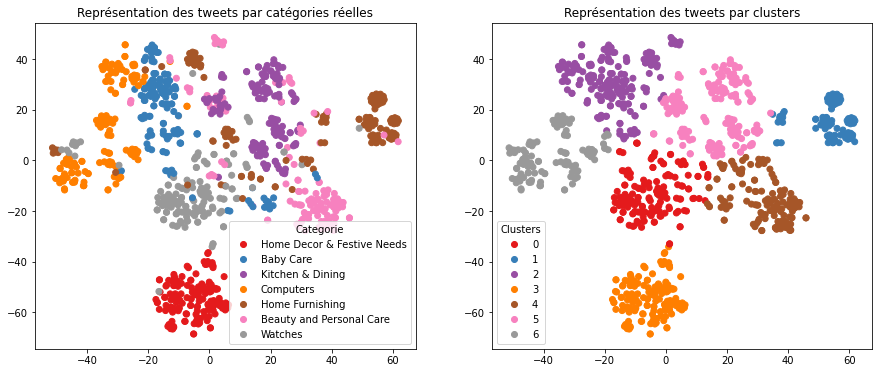

ARI :  0.5401


In [ ]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Word2Vec

word2vec dense - le mot possède une représentation dans un espace qui le positionne en fonction des mots adjacents

In [ ]:
#pip install gensim

In [ ]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [ ]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = df['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [ ]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4688
Word2Vec trained


In [ ]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4689


## Création de la matrice d'embedding

In [ ]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0

for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4689, 300)


## Création du modèle d'embedding

In [ ]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1406700   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,406,700
Trainable params: 1,406,700
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle Word2Vec

In [ ]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 2s 5ms/step


(1050, 300)

In [ ]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.2159 time :  9.0


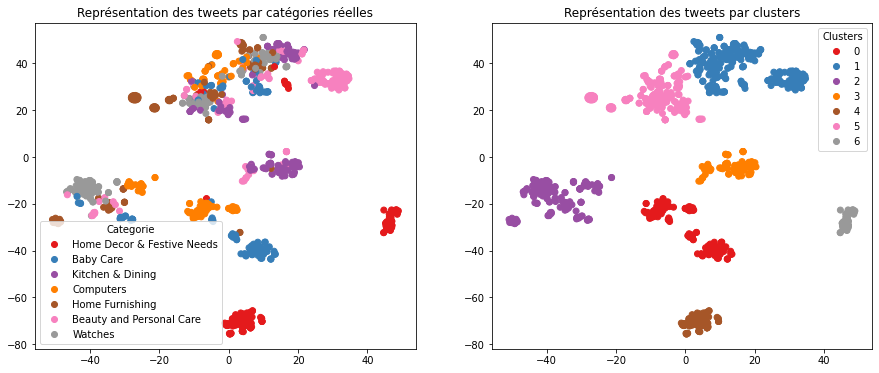

ARI :  0.2159


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so, 6): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: /Users/markobri

In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.11.1
2.11.1
Num GPUs Available:  0
False


## BERT : Fonctions communes

In [ ]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in sentences:
        # Encodage de la phrase avec le tokenizer BERT
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        # Ajout des résultats aux listes respectives
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    # Conversion des listes en tableaux NumPy
    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    # Retourne les tableaux NumPy et la liste complète des entrées BERT
    return input_ids, token_type_ids, attention_mask, bert_inp_tot



# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['sentence_dl'].to_list()

loading configuration file config.json from cache at /Users/markobriesemann/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at /Users/markobriesemann/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff

In [ ]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at /Users/markobriesemann/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



loading file vocab.txt from cache at /Users/markobriesemann/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/vocab.txt
loading file tokenizer.json from cache at /Users/markobriesemann/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/markobriesemann/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer_config.json
loading configuration file config.json from cache at /Users/markobriesemann/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classi

1/1 [==============================] - 0s 487ms/step
temps traitement :  74.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.319 time :  4.0


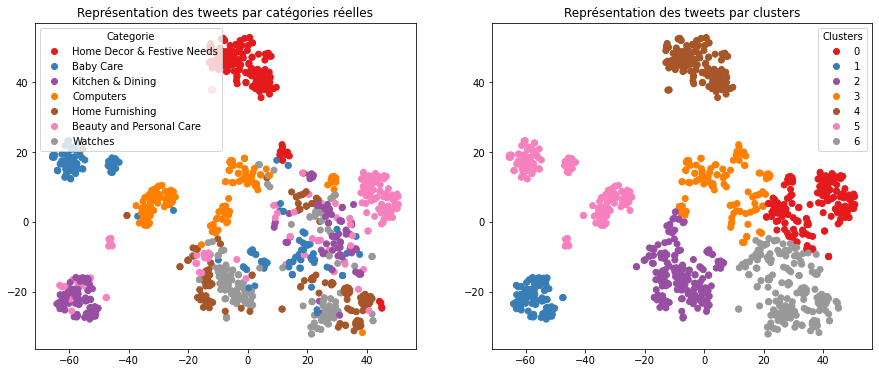

ARI :  0.319


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [ ]:
import tensorflow_hub as hub
import tensorflow_text

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [ ]:
#sentences = data_T['sentence_dl'].to_list()

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')

loading configuration file config.json from cache at /Users/markobriesemann/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/markobriesemann/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64

temps traitement :  57.0


ARI :  0.3166 time :  4.0


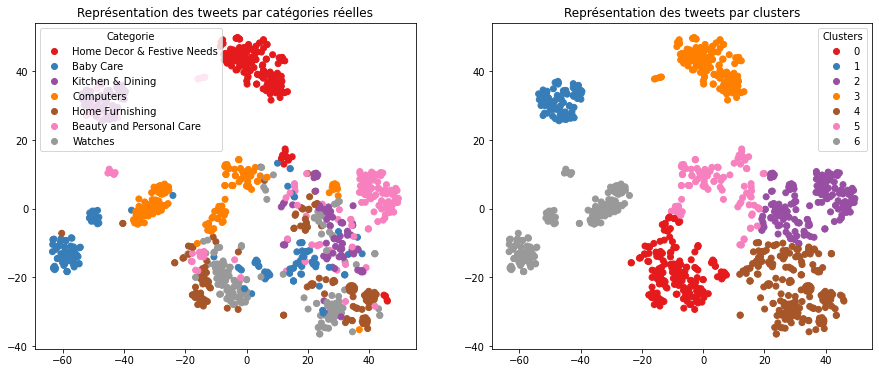

ARI :  0.3166


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## USE - Universal Sentence Encoder

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.11.1
2.11.1
Num GPUs Available:  0
False


In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

ARI :  0.432 time :  4.0


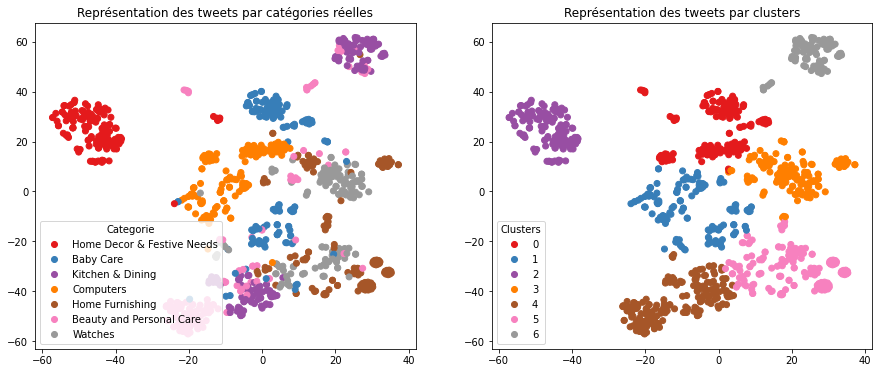

ARI :  0.432


In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

batch_size = 10
#sentences = data_T['sentence_dl'].to_list()

features_USE = feature_USE_fct(sentences, batch_size)

ARI, X_tsne, labels = ARI_fct(features_USE)

TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

**Analyse graphique**